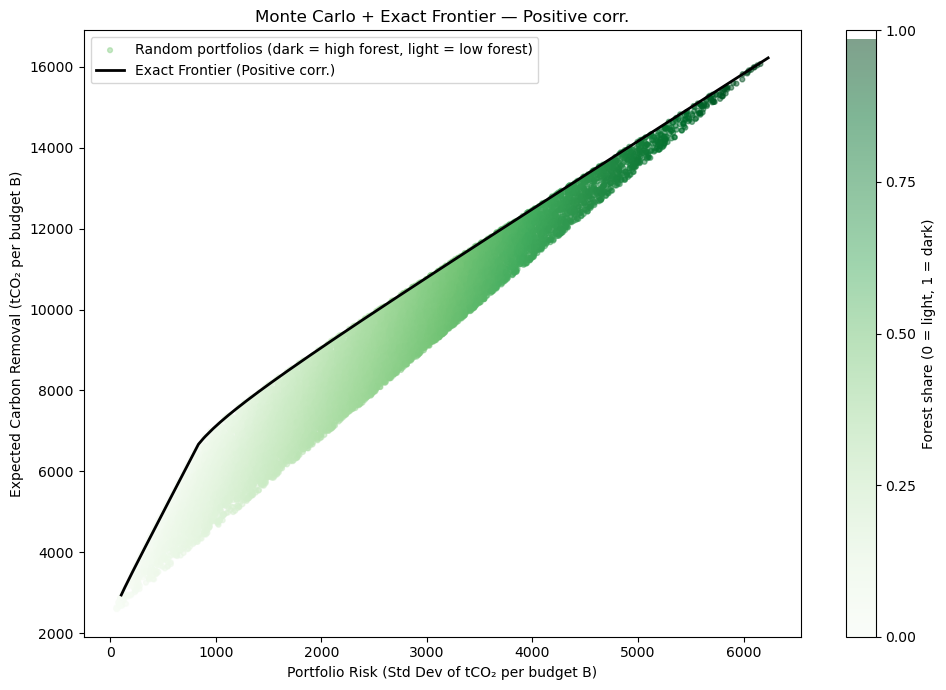

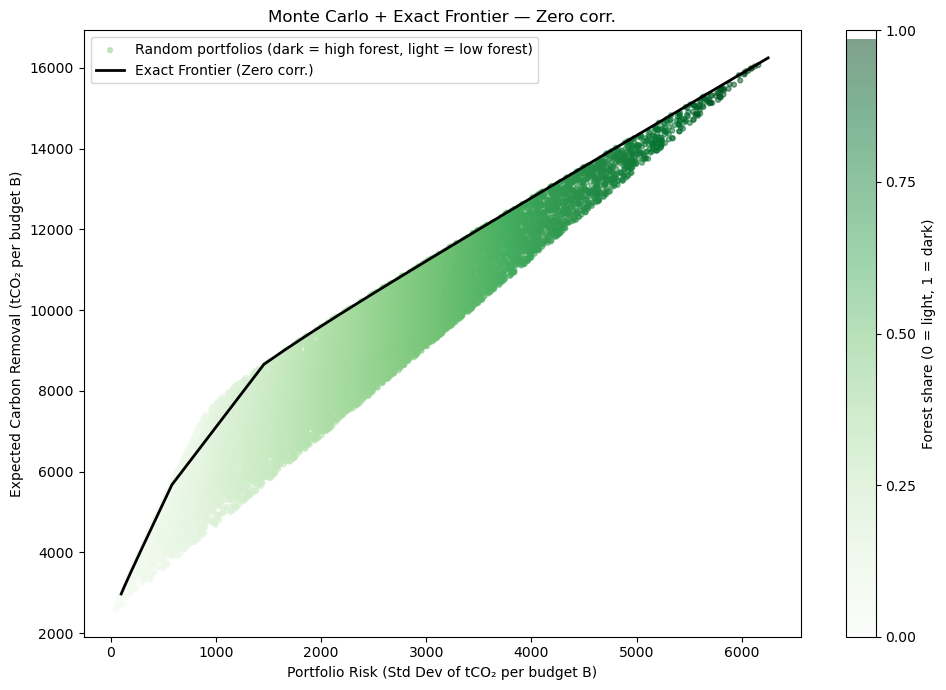

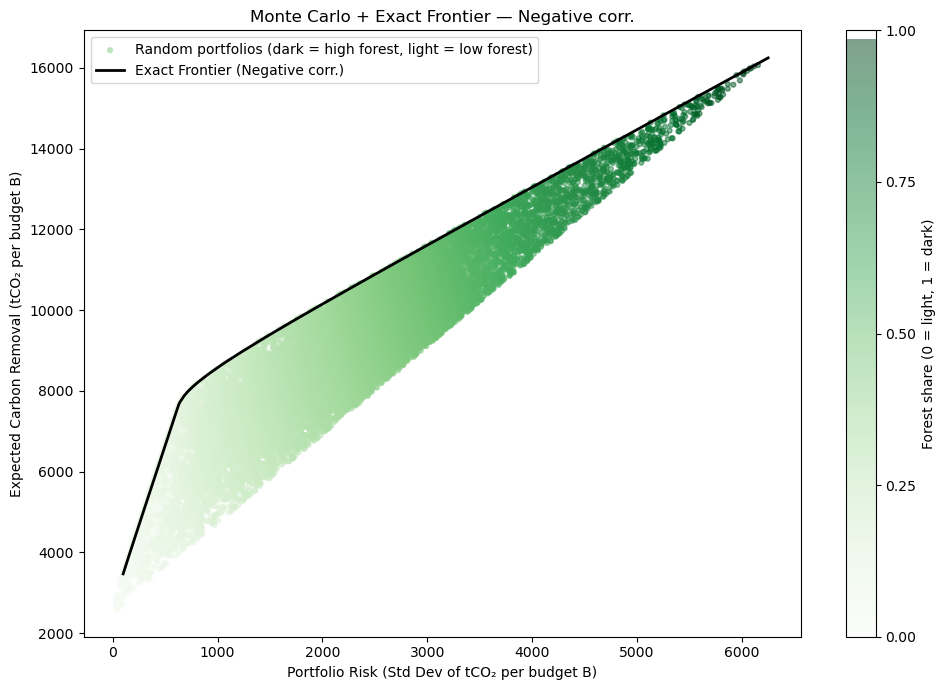

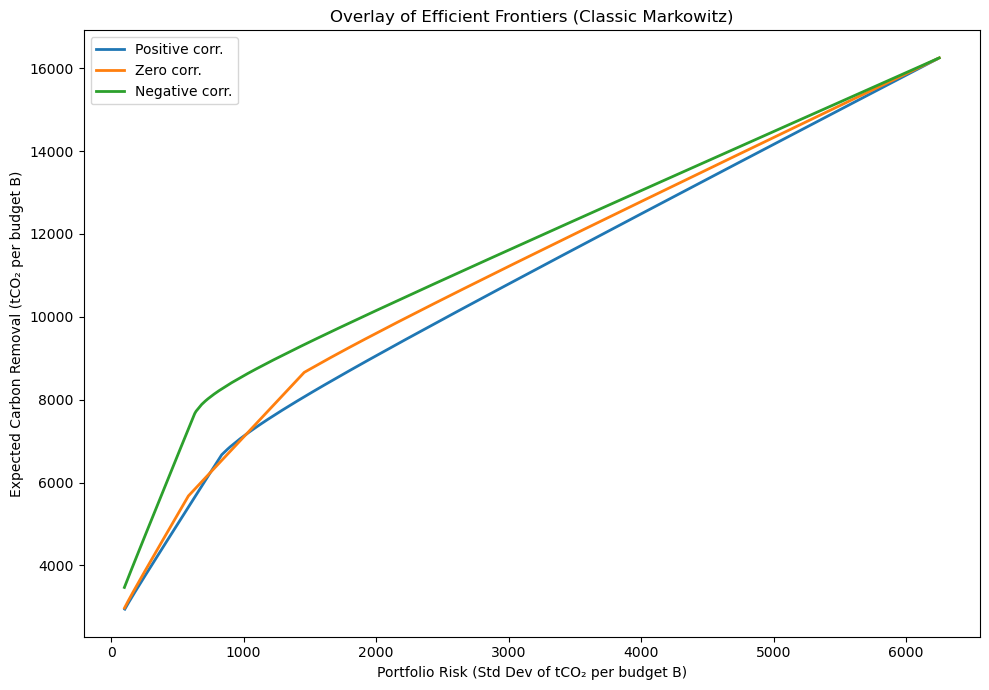

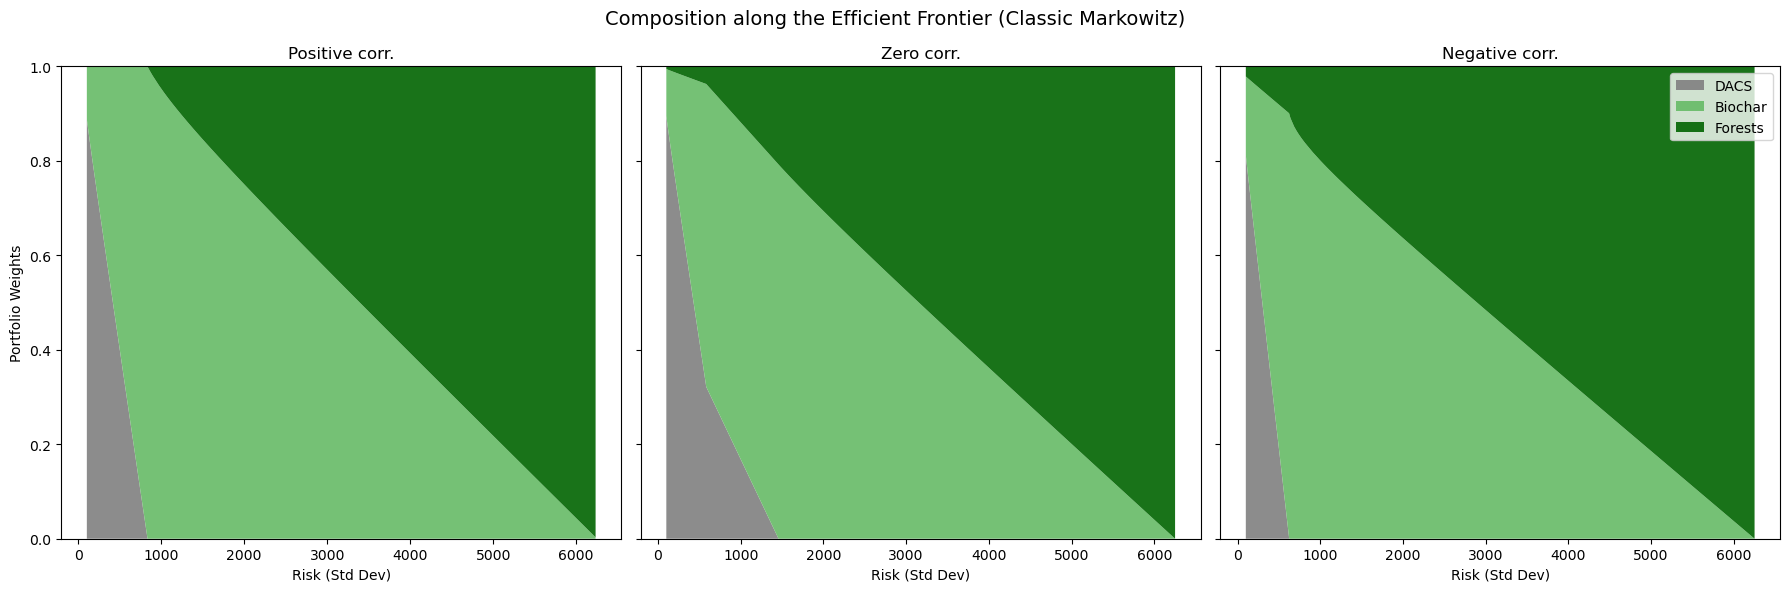


All files saved to: /home/9b5c5a7f-2423-46af-b6f2-a60b7c41c7b7/CAR_files/
 - covariance_*.csv (per scenario)
 - scatter_frontier_*.png (per scenario)
 - overlay_frontiers.png
 - composition_frontiers.png
 - sample_portfolios.csv


In [21]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Carbon removal portfolios with within- and between-type variance structure.
- Within-type scaling via project size q_i and rho_within_i
- Between-type correlations via rho_between matrix
- Monte Carlo scatter (green shading: dark = high forest)
- Exact efficient frontier (classic target-return Markowitz, SLSQP)
- PSD repair + safe sqrt for numerical robustness
- Saves figures/CSV to folder; also shows plots
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# -------------------------------
# 0) Output folder
# -------------------------------
OUT_DIR = "/home/9b5c5a7f-2423-46af-b6f2-a60b7c41c7b7/CAR_files/"
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------------
# 1) Inputs (budget, technologies, survival stats)
# -------------------------------
B = 1_000_000.0  # example budget $1m (used only to scale tonnes; methods use generic B)

projects = ["DACS", "Biochar", "Forests"]

# Cost per tonne ($/t) and survival probability (mean permanence)
c = np.array([400.0, 120.0, 40.0])      # costs
pi = np.array([0.99, 0.80, 0.65])       # survival probabilities

# Survival std dev (variance of delivery fraction)
sigma = np.array([0.02, 0.10, 0.25])

# Project size q_i (tCO2 per project)
# Default = 500 t per project, an assumption to reduce diversification effect.
q = np.array([200.0, 200.0, 200.0])

# Within-type correlation rho_within_i (default ~1 for 500t projects; adjust if desired)
rho_within = np.array([1.0, 1.0, 1.0])

# Expected tonnes per $B invested (return vector mu)
mu = (B / c) * pi  # tCO2 per budget B

# Number of projects per technology under budget B (can be fractional; formula uses n_i formally)
Q = B / c
n = Q / q  # projects count (effective), used in variance scaling factor

# -------------------------------
# 2) Between-type correlation scenarios (rho_between)
#    You can adjust magnitudes to make contrasts more/less stark.
# -------------------------------
rho_between_scenarios = {
    "Positive corr.": np.array([[1.0,  0,  0.6],
                                [0,  1.0,  0.6],
                                [0.6,  0.6,  1.0]]),
    "Zero corr.":     np.eye(3),
    "Negative corr.": np.array([[ 1.0, 0, -0.6],
                                [0,  1.0, -0.6],
                                [-0.6, -0.6,  1.0]]),
}

# -------------------------------
# 3) Helpers (PSD repair, covariance builder, MC, optimiser)
# -------------------------------
def repair_psd(matrix, tol=1e-12):
    """Eigenvalue flooring to ensure PSD."""
    vals, vecs = np.linalg.eigh(matrix)
    vals[vals < tol] = 0.0
    return vecs @ np.diag(vals) @ vecs.T

def within_variance_terms(B, c, sigma, n, rho_within):
    """
    Diagonal entries Var(X_i) = (B/c_i)^2 * sigma_i^2 * [1+(n_i-1)*rho_within_i]/n_i
    """
    scale = (B / c)**2 * (sigma**2)
    factor = (1.0 + (n - 1.0) * rho_within) / np.maximum(n, 1e-12)
    return scale * factor

def covariance_matrix(B, c, sigma, q, rho_within, rho_between):
    """
    Build full covariance matrix Sigma with:
      diag: within-type scaling (project granularity & rho_within)
      off-diag: between-type correlations (rho_between)
    """
    # Diagonals
    n = (B / c) / q
    diag = within_variance_terms(B, c, sigma, n, rho_within)

    # Off-diagonals: Cov(X_i, X_j) = (B/c_i)(B/c_j) * sigma_i*sigma_j * rho_between_ij
    # Start with outer product of (B/c)*sigma
    base = np.outer((B / c) * sigma, (B / c) * sigma)
    Sigma = base * rho_between

    # overwrite diagonal with the within-type expression
    np.fill_diagonal(Sigma, diag)

    # PSD repair for numerical safety
    Sigma = repair_psd(Sigma)
    return Sigma

def safe_vol(w, Sigma):
    var = float(w @ Sigma @ w)
    return float(np.sqrt(max(var, 0.0)))

def monte_carlo(mu, Sigma, n_draws=20000, seed=42):
    rng = np.random.default_rng(seed)
    k = len(mu)
    rows = []
    for _ in range(n_draws):
        w = rng.random(k); w /= w.sum()
        R = float(w @ mu)
        s = safe_vol(w, Sigma)
        rows.append([R, s, *w])
    return pd.DataFrame(rows, columns=["Return", "Risk", *projects])

def exact_frontier(mu, Sigma, n_points=400):
    """
    Classic Markowitz: min w' Sigma w s.t. sum w = 1, w >= 0, and mu'w = T (equality).
    """
    k = len(mu)
    bounds = [(0.0, 1.0)] * k
    Ts = np.linspace(mu.min() + 1e-6, mu.max(), n_points)
    results = []
    for T in Ts:
        cons = (
            {"type": "eq", "fun": lambda w: np.sum(w) - 1.0},
            {"type": "eq", "fun": lambda w, T=T: float(w @ mu) - float(T)},
        )
        x0 = np.full(k, 1.0 / k)
        res = minimize(lambda w: float(w @ Sigma @ w), x0, bounds=bounds, constraints=cons, 
                       method = "SLSQP", options={"ftol": 1e-12, "maxiter": 3000})
        if res.success:
            w = res.x
            results.append([float(w @ mu), safe_vol(w, Sigma), *w])
    return pd.DataFrame(results, columns=["Return", "Risk", *projects]).sort_values("Risk")

# -------------------------------
# 4) Run scenarios: build Sigma, MC, exact frontier, save & show
# -------------------------------
frontier_data = {}

for label, rho_between in rho_between_scenarios.items():
    # Build Sigma with within- & between-type structure
    Sigma = covariance_matrix(B, c, sigma, q, rho_within, rho_between)

    # Save the covariance matrix
    pd.DataFrame(Sigma, index=projects, columns=projects)\
      .to_csv(os.path.join(OUT_DIR, f"covariance_{label.replace(' ','_')}.csv"), index=True)

    # Monte Carlo & exact frontier
    df_mc = monte_carlo(mu, Sigma, n_draws=20000, seed=42)
    df_front = exact_frontier(mu, Sigma, n_points=500)

    # Optional trimming for very low-risk numerical quirks (common in negative corr.):
    df_front_trim = df_front[df_front["Risk"] > 100].copy()

    frontier_data[label] = (df_mc, df_front_trim)

    # --- Scatter + frontier plot (green shading: dark = high forest) ---
    plt.figure(figsize=(10, 7))
    sc = plt.scatter(df_mc["Risk"], df_mc["Return"],
                     c=df_mc["Forests"], cmap="Greens", alpha=0.5, s=12,
                     label="Random portfolios (dark = high forest, light = low forest)")
    plt.plot(df_front_trim["Risk"], df_front_trim["Return"], color="black", lw=2,
             label=f"Exact Frontier ({label})")
    plt.xlabel("Portfolio Risk (Std Dev of tCO₂ per budget B)")
    plt.ylabel("Expected Carbon Removal (tCO₂ per budget B)")
    plt.title(f"Monte Carlo + Exact Frontier — {label}")
    cbar = plt.colorbar(sc)
    cbar.set_label("Forest share (0 = light, 1 = dark)")
    cbar.set_ticks([0.0, 0.25, 0.5, 0.75, 1.0])
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"scatter_frontier_{label.replace(' ','_')}.png"), dpi=300)
    plt.show()

# -------------------------------
# 5) Overlay of all exact frontiers
# -------------------------------
plt.figure(figsize=(10, 7))
for label, (df_mc, df_front) in frontier_data.items():
    plt.plot(df_front["Risk"], df_front["Return"], lw=2, label=label)
plt.xlabel("Portfolio Risk (Std Dev of tCO₂ per budget B)")
plt.ylabel("Expected Carbon Removal (tCO₂ per budget B)")
plt.title("Overlay of Efficient Frontiers (Classic Markowitz)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "overlay_frontiers.png"), dpi=300)
plt.show()

# -------------------------------
# 6) Composition plots (consistent colours)
# -------------------------------
colors = {"DACS": "grey", "Biochar": "#66bb66", "Forests": "#006400"}  # grey, medium green, dark green

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for ax, (label, (df_mc, df_front)) in zip(axes, frontier_data.items()):
    x = df_front["Risk"].to_numpy()
    ax.stackplot(x,
                 df_front["DACS"], df_front["Biochar"], df_front["Forests"],
                 labels=projects,
                 colors=[colors["DACS"], colors["Biochar"], colors["Forests"]],
                 alpha=0.9)
    ax.set_title(label)
    ax.set_xlabel("Risk (Std Dev)")
    ax.set_ylim(0, 1)
axes[0].set_ylabel("Portfolio Weights")
axes[-1].legend(loc="upper right")
fig.suptitle("Composition along the Efficient Frontier (Classic Markowitz)", fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "composition_frontiers.png"), dpi=300)
plt.show()

# -------------------------------
# 7) Sample portfolios table (low/mid/high risk per scenario)
# -------------------------------
samples = []
for label, (df_mc, df_front) in frontier_data.items():
    take = df_front.iloc[[0, len(df_front)//2, -1]].copy()
    take.insert(0, "Scenario", label)
    samples.append(take)
summary = pd.concat(samples, ignore_index=True)
summary.to_csv(os.path.join(OUT_DIR, "sample_portfolios.csv"), index=False)

print(f"\nAll files saved to: {OUT_DIR}")
print(" - covariance_*.csv (per scenario)")
print(" - scatter_frontier_*.png (per scenario)")
print(" - overlay_frontiers.png")
print(" - composition_frontiers.png")
print(" - sample_portfolios.csv")
